In [114]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests


from importlib import reload
import warnings
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker


# Setting up API retrieval from Google Sheets

> Make sure to have installed the necessary packages in your conda environment
>>```
conda activate base
pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib
pip install gspread oauth2client df2gspread

> Have `credentials.json` in your working directory

> Have `servicecredentials.json` in your working directory

> Share your Google sheet with your service account: `google-sheets@third-faculty-385421.iam.gserviceaccount.com`

> Get spreadsheet key from your Google sheet and identify the worksheet you want

In [5]:
#The scope is always look like this so we did not need to change anything
import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
#Name of our Service Account Key
google_key_file = 'servicecredentials-Copy1.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

In [6]:
#This is the Worksheet ID
spreadsheet_key = '1jfjQkobvAVB4eIjg6sK3lKis1l-_czaeoK7tGZfg8VE'
#This is the sheet name
wks_name = 'Sheet1'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_name)

#Pulling the data and transform it to the data frame
values = sheet.get_all_values()
df = pd.DataFrame(values[1:], columns = values[0])
df

,station_id,longitude,latitude,time,SST,SSS,pCO2_sw,pCO2_air,xCO2_air,pH_sw,DOXY,CHL,NTU,fCO2,OmegaAr
0,BOBOA,90.5,15.5,2014-12-07 15:17,28.49,32.488,383.5,381.6,397.2,8.036,186.7,0.031,0.068,382.3273008448767,3.2631341272992214
1,BOBOA,90.5,15.5,2014-12-08 15:17,28.632,32.722,379.8,382.5,397.8,8.038,187.0,0.038,0.075,378.6405918683633,3.2926811598165187
2,BOBOA,90.5,15.5,2014-12-08 18:17,28.615,32.767,381.6,381.9,397.3,8.04,186.5,0.031,0.07,380.4348594899831,3.340531363907172
3,BOBOA,90.5,15.5,2014-12-09 15:17,28.528,32.469,373.2,389.7,404.8,8.053,188.3,0.035,0.069,372.0593173140736,3.4365319630247337
4,BOBOA,90.5,15.5,2014-12-09 18:17,28.467,32.529,376.0,387.9,403.2,8.056,188.2,0.02,0.063,374.8499175866859,3.5088012750829485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10619,whots,-157.5,22.5,2019-05-12 09:17,25.18,34.535,395.4,399.4,410.4,8.061,212.2,0.127,0.126,394.1416049517789,3.559458611673408
10620,whots,-157.5,22.5,2019-05-12 12:17,25.119,34.527,392.1,399.0,410.5,8.06,212.2,0.118,0.171,390.8511819379163,3.5061778309806066
10621,whots,-157.5,22.5,2019-05-13 09:17,25.476,34.566,392.7,400.2,411.0,8.061,210.9,0.122,0.213,391.45468314036924,3.5706138573292034
10622,whots,-157.5,22.5,2019-05-13 12:17,25.477,34.573,397.3,399.5,410.8,8.054,211.1,0.119,0.044,396.04011107080186,3.498439109757426


# Convert strings to appropriate data types
i.e. convert longitude strings to longitude numerics

In [26]:
df['longitude'] = pd.to_numeric(df['longitude'])
df['latitude'] = pd.to_numeric(df['latitude'])
df['pCO2_air'] = pd.to_numeric(df['pCO2_air'])
df['xCO2_air'] = pd.to_numeric(df['xCO2_air'])
df['pCO2_sw'] = pd.to_numeric(df['pCO2_sw'])
df['pH_sw'] = pd.to_numeric(df['pH_sw'])
df['SST'] = pd.to_numeric(df['SST'])
df['SSS'] = pd.to_numeric(df['SSS'])
df['DOXY'] = pd.to_numeric(df['DOXY'])
df['CHL'] = pd.to_numeric(df['CHL'])
df['NTU'] = pd.to_numeric(df['NTU'])
df['fCO2'] = pd.to_numeric(df['fCO2'])
df['OmegaAr'] = pd.to_numeric(df['OmegaAr'])
df["time"] = pd.to_datetime(df["time"])
df.head()

,station_id,longitude,latitude,time,SST,SSS,pCO2_sw,pCO2_air,xCO2_air,pH_sw,DOXY,CHL,NTU,fCO2,OmegaAr
0,BOBOA,90.5,15.5,2014-12-07 15:17:00,28.490,32.488,383.5,381.6,397.2,8.036,186.7,0.031,0.068,382.327301,3.263134
1,BOBOA,90.5,15.5,2014-12-08 15:17:00,28.632,32.722,379.8,382.5,397.8,8.038,187.0,0.038,0.075,378.640592,3.292681
2,BOBOA,90.5,15.5,2014-12-08 18:17:00,28.615,32.767,381.6,381.9,397.3,8.040,186.5,0.031,0.070,380.434859,3.340531
3,BOBOA,90.5,15.5,2014-12-09 15:17:00,28.528,32.469,373.2,389.7,404.8,8.053,188.3,0.035,0.069,372.059317,3.436532
4,BOBOA,90.5,15.5,2014-12-09 18:17:00,28.467,32.529,376.0,387.9,403.2,8.056,188.2,0.020,0.063,374.849918,3.508801


# Calculate standard deviations
## Create data frame to store Std data

In [104]:
dat = np.zeros(len(df['station_id'].unique()))
dat[:] = np.nan
data = {df.keys()[0]: df['station_id'].unique(),
        df.keys()[1]: dat,              # lon
        df.keys()[2]: dat,              # lat
        df.keys()[3] + '_min': dat,     # time min
        df.keys()[3] + '_max': dat,     # time max
        df.keys()[3] + '_range': dat,   # time range
        df.keys()[4] + '_Std': dat,     # SST Std
        df.keys()[5] + '_Std': dat,     # SSS Std
        df.keys()[6] + '_Std': dat,     # pCO2_sw Std
        df.keys()[7] + '_Std': dat,     # pCO2_air Std
        df.keys()[8] + '_Std': dat,     # xCO2 Std
        df.keys()[9] + '_Std': dat,     # pH Std
        df.keys()[13] + '_Std': dat,    # fCO2 Std
        df.keys()[14] + '_Std': dat}    # OmegaAr Std
dd = pd.DataFrame(data)
dd

,station_id,longitude,latitude,time_min,time_max,time_range,SST_Std,SSS_Std,pCO2_sw_Std,pCO2_air_Std,xCO2_air_Std,pH_sw_Std,fCO2_Std,OmegaAr_Std
0,BOBOA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,capearago,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cce1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cce2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,lapush,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,cheeca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,chuukk1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,coastalla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,CBIBS_FirstLanding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ndbcga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Write Stds to `dd` dataframe 

In [105]:
i = 0
for item in dd['station_id'].unique():
    it = df.where(df['station_id'] == item).dropna()
    dd['longitude'].loc[i] = it['longitude'].mean()
    dd['latitude'].loc[i] = it['latitude'].mean()
    dd['time_min'].loc[i] = it['time'].min()
    dd['time_max'].loc[i] = it['time'].max()
    dd['time_range'].loc[i] = it['time'].max() - it['time'].min()
    dd['SST_Std'].loc[i] = it['SST'].std()
    dd['SSS_Std'].loc[i] = it['SSS'].std()
    dd['pCO2_sw_Std'].loc[i] = it['pCO2_sw'].std()
    dd['pCO2_air_Std'].loc[i] = it['pCO2_air'].std()
    dd['xCO2_air_Std'].loc[i] = it['xCO2_air'].std()
    dd['pH_sw_Std'].loc[i] = it['pH_sw'].std()
    dd['fCO2_Std'].loc[i] = it['fCO2'].std()
    dd['OmegaAr_Std'].loc[i] = it['OmegaAr'].std()
    i += 1


## Export Std data to google sheet 
https://docs.google.com/spreadsheets/d/1jfjQkobvAVB4eIjg6sK3lKis1l-_czaeoK7tGZfg8VE/edit#gid=302097679

In [107]:
#This is the Worksheet ID
spreadsheet_key = '1jfjQkobvAVB4eIjg6sK3lKis1l-_czaeoK7tGZfg8VE'
#This is the sheet name
wks_name = 'Std'
#We upload the tips data to our Google Sheet. Setting the row_names to False if you did not want the index to be included
d2g.upload(dd, spreadsheet_key, wks_name, credentials=credentials, row_names=False)

<Worksheet 'Std' id:302097679>

# Calculate means
## Create dataframe to store Mn data

In [108]:
dat = np.zeros(len(df['station_id'].unique()))
dat[:] = np.nan
data = {df.keys()[0]: df['station_id'].unique(),
        df.keys()[1]: dat,              # lon
        df.keys()[2]: dat,              # lat
        df.keys()[3] + '_min': dat,     # time min
        df.keys()[3] + '_max': dat,     # time max
        df.keys()[3] + '_range': dat,   # time range
        df.keys()[4] + '_Mn': dat,      # SST Mn
        df.keys()[5] + '_Mn': dat,      # SSS Mn
        df.keys()[6] + '_Mn': dat,      # pCO2_sw Mn
        df.keys()[7] + '_Mn': dat,      # pCO2_air Mn
        df.keys()[8] + '_Mn': dat,      # xCO2 Mn
        df.keys()[9] + '_Mn': dat,      # pH Mn
        df.keys()[13] + '_Mn': dat,     # fCO2 Mn
        df.keys()[14] + '_Mn': dat}     # OmegaAr Mn
dd_mean = pd.DataFrame(data)
dd_mean

,station_id,longitude,latitude,time_min,time_max,time_range,SST_Mn,SSS_Mn,pCO2_sw_Mn,pCO2_air_Mn,xCO2_air_Mn,pH_sw_Mn,fCO2_Mn,OmegaAr_Mn
0,BOBOA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,capearago,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cce1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cce2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,lapush,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,cheeca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,chuukk1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,coastalla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,CBIBS_FirstLanding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ndbcga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculate means and write to `dd_mean`

In [109]:
i = 0
for item in dd_mean['station_id'].unique():
    it = df.where(df['station_id'] == item).dropna()
    dd_mean['longitude'].loc[i] = it['longitude'].mean()
    dd_mean['latitude'].loc[i] = it['latitude'].mean()
    dd_mean['time_min'].loc[i] = it['time'].min()
    dd_mean['time_max'].loc[i] = it['time'].max()
    dd_mean['time_range'].loc[i] = it['time'].max() - it['time'].min()
    dd_mean['SST_Mn'].loc[i] = it['SST'].mean()
    dd_mean['SSS_Mn'].loc[i] = it['SSS'].mean()
    dd_mean['pCO2_sw_Mn'].loc[i] = it['pCO2_sw'].mean()
    dd_mean['pCO2_air_Mn'].loc[i] = it['pCO2_air'].mean()
    dd_mean['xCO2_air_Mn'].loc[i] = it['xCO2_air'].mean()
    dd_mean['pH_sw_Mn'].loc[i] = it['pH_sw'].mean()
    dd_mean['fCO2_Mn'].loc[i] = it['fCO2'].mean()
    dd_mean['OmegaAr_Mn'].loc[i] = it['OmegaAr'].mean()
    i += 1

In [110]:
dd_mean

,station_id,longitude,latitude,time_min,time_max,time_range,SST_Mn,SSS_Mn,pCO2_sw_Mn,pCO2_air_Mn,xCO2_air_Mn,pH_sw_Mn,fCO2_Mn,OmegaAr_Mn
0,BOBOA,90.5,15.5,2014-12-07 15:17:00,2017-05-31 18:17:00,906 days 03:00:00,28.478712,32.590034,385.270392,387.076457,403.112485,8.044010,384.092950,3.401546
1,capearago,-124.5,43.5,2017-06-10 05:17:00,2021-04-11 09:17:00,1401 days 04:00:00,12.005477,32.669848,407.849785,409.390886,412.736629,8.058125,406.314489,2.299583
2,cce1,-122.5,33.5,2018-11-14 06:47:00,2019-02-20 09:17:00,98 days 02:30:00,15.896283,33.406631,383.171212,408.055051,412.483838,8.052455,381.803200,2.345564
3,cce2,-120.5,34.5,2020-09-09 06:17:00,2021-01-14 09:17:00,127 days 03:00:00,14.999406,33.455813,396.589062,410.253516,415.968750,8.044109,395.154399,2.263926
4,lapush,-125.5,47.5,2012-05-26 06:17:00,2022-01-30 09:16:00,3536 days 02:59:00,11.800340,31.467273,336.093862,402.442591,406.655983,8.099720,334.826975,2.064932
5,cheeca,-80.5,24.5,2017-03-30 06:17:00,2020-05-24 06:17:00,1151 days 00:00:00,28.439021,36.763360,373.054884,394.558837,409.208837,8.072037,371.914595,4.067666
6,chuukk1,151.5,7.5,2013-04-24 12:17:00,2016-03-05 12:17:00,1046 days 00:00:00,29.085948,34.095569,398.369758,377.571237,395.391129,8.013046,397.160331,3.213588
7,coastalla,-90.5,28.5,2019-11-12 03:17:00,2019-12-05 09:17:00,23 days 06:00:00,20.623845,29.273070,313.578873,411.035211,418.870423,8.171169,312.523937,3.488881
8,CBIBS_FirstLanding,-76.5,36.5,2018-04-27 03:17:00,2018-05-11 03:17:00,14 days 00:00:00,15.232667,21.573926,438.637037,419.622222,425.381481,7.983667,437.056809,1.319585
9,ndbcga,-80.5,31.5,2011-10-01 03:17:00,2017-07-23 03:17:00,2122 days 00:00:00,25.203078,35.502821,423.321076,389.744913,400.886047,8.029012,421.978291,3.337924


## Export means to google sheet
https://docs.google.com/spreadsheets/d/1jfjQkobvAVB4eIjg6sK3lKis1l-_czaeoK7tGZfg8VE/edit#gid=1340084960

In [111]:
#This is the Worksheet ID
spreadsheet_key = '1jfjQkobvAVB4eIjg6sK3lKis1l-_czaeoK7tGZfg8VE'
#This is the sheet name
wks_name = 'Mean'
#We upload the tips data to our Google Sheet. Setting the row_names to False if you did not want the index to be included
d2g.upload(dd_mean, spreadsheet_key, wks_name, credentials=credentials, row_names=False)

<Worksheet 'Mean' id:1340084960>

# Test plots

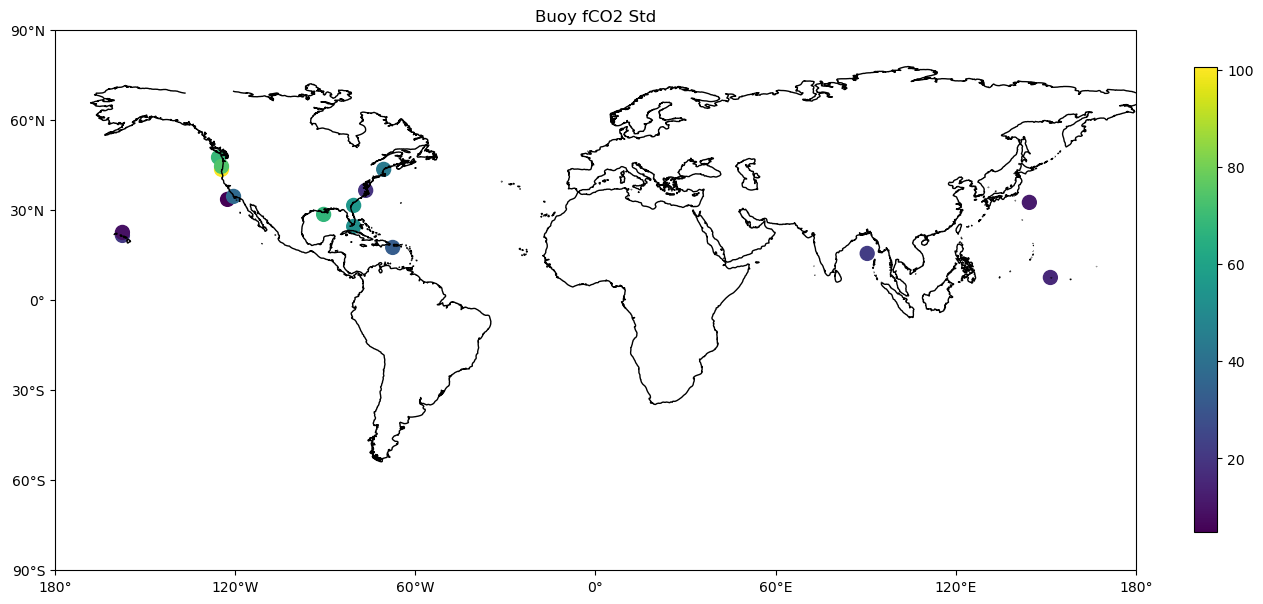

In [120]:
fig, ax = plt.subplots(figsize=[15,15], subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
im = ax.scatter(dd['longitude'], dd['latitude'], c = dd['fCO2_Std'], s = 100)
cbar = plt.colorbar(im, ax= ax, fraction = 0.02)
ax.set_title('Buoy fCO2 Std')

ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)